# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/gaia/
!ls

In [ ]:
! pwd

# Download data

In [ ]:
!wget -O galah_dr4_allstar_240705.fits https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_allstar_240705.fits
!wget -O galah_dr4_vac_dynamics_240705.fits https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_vac_dynamics_240705.fits

In [ ]:
# Download external data:
download = False
if download:
    # !wget -O ONeill2024_LocalBubble_ShellProperties_A0.5.fits https://dataverse.harvard.edu/api/access/datafile/8943783
    !wget -O ONeill2024_LocalBubble_Shell_xyz.fits https://dataverse.harvard.edu/api/access/datafile/8955365
    # RHI CNN maps and uncertainties
    # !wget -O rhi_zea.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/E0HLON/WJZMPD
    # Observed catalog
    # !wget -O catalogged_verification.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/MJGQAY/D2RS4E

# Install

In [ ]:
# ! pip install healpy --quiet

In [ ]:
# ! pip install wget --quiet

# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

import healpy as hp
from scipy.stats import binned_statistic_2d

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable ## for Plotting L.O.S Samples
import matplotlib.gridspec as gridspec

import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
# from torch.utils.data import Dataset, DataLoader


from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.6.0+cu124
torch.version.cuda:  12.4
Is CUDA enabled? False


# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = ml_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

In [ ]:
# %cd /content/gdrive/MyDrive/Colab Notebooks/GASKAP

In [ ]:
# %ls

# Fcn

In [ ]:
vlsr_sun = 15.17 # km/s, see Sven's paper GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def plot_star_hi_abs(GASS_nhi_thin_map, glon_cnm, glat_cnm, glon_det, glat_det, hi_det_src_id, closest_coords_glon, closest_coords_glat):
    xlbs = 18
    tlbs = 16
    cmap = 'viridis'
    cmap = 'bwr'

    cm = mpl.colormaps['cool'] # winter, cool, hsv, jet


    # Plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection=w)

    # Display the moment map image
    im = ax.imshow(GASS_nhi_thin_map, cmap='gray')
    # ax.invert_yaxis()  # Flips the Y axis
    # ax.invert_xaxis()  # Flips the X axis


    # sct = ax.scatter(src_gl_LMC, src_gb_LMC, s=40, transform=ax.get_transform('galactic'),
    #            marker='s', c=noise_LMC_percent,
    #            cmap='jet',
    #            norm=mpl.colors.LogNorm(vmin=noise_LMC_percent_min, vmax=100.),
    #            label='MW')

    sct = ax.scatter(glon_cnm, glat_cnm, s=40, c=vcencnm, transform=ax.get_transform('galactic'),
              marker='o', cmap=cmap, # vmin=-10, vmax=10., # norm=mpl.colors.LogNorm(vmin=0.01, vmax=0.2), # vmin=0.01, vmax=0.06, # vmax=n_k_is.max(),
              label='HI absorption detections')
    ax.scatter(glon_det[hi_det_src_id], glat_det[hi_det_src_id], s=150, transform=ax.get_transform('galactic'), marker='x', c='c', alpha=0.8, label='Absorption L.O.S')
    ax.scatter(closest_coords_glon, closest_coords_glat, s=110, transform=ax.get_transform('galactic'), marker='*', c='magenta', alpha=0.8, label='Star')

    ax.plot(ch_xcirc, ch_ycirc,
            transform=ax.get_transform('galactic'),
            lw=3.5,
            c='lightcyan',
            ls='--',
            zorder=0,
            alpha=0.5,
            label='Horizontal filament'
          )

    ax.plot(cv_xcirc, cv_ycirc,
            transform=ax.get_transform('galactic'),
            lw=3.5,
            c='gray',
            ls='--',
            alpha=0.5,
            zorder=0,
            label='Vertical filament'
          )


    # Approximate locations of LMC, SMC
    ax.plot(SMC_xcirc,
            SMC_ycirc,
            transform=ax.get_transform('galactic'),
            lw=2.,
            color='r',
            ls='--',
            label='Toward SMC'
          )
    ax.plot(LMC_xcirc,
            LMC_ycirc,
            transform=ax.get_transform('galactic'),
            lw=2.,
            color='y',
            ls='--',
            label='Toward LMC'
          )



    # Title
    # ax.set_title(f"LMC: {n_fields} fields, {n_sightlines} sources", fontsize=18)

    # Add axes labels
    ax.set_xlabel('Galactic Longitude [degrees]', fontsize=xlbs)
    ax.set_ylabel('Galactic Latitude [degrees]', fontsize=xlbs)

    # Add a colorbar
    # cbar = plt.colorbar(im, pad=.07)
    # cbar.set_label('Velocity (km/s)', size=16)

    # Color bar
    cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.01, pad=0.006, aspect=55)
    cbar.ax.set_ylabel('CNM Velocity [km/s]', rotation=90, labelpad=5., fontsize=15)
    cbar.ax.tick_params(labelsize=16)

    # Overlay set of RA/Dec Axes
    # overlay = ax.get_coords_overlay('fk5')
    # overlay.grid(color='white', ls='dotted', lw=0.3)
    # overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
    # overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

    # Overplot column density contours
    # levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
    # ax.contour(NHI.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=tlbs, pad=4)
    ax.tick_params(axis='y', labelsize=tlbs)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=4)


    ax.legend(loc='upper left', fontsize=16)

    plt.grid(color='gray', lw=0.5)
    plt.show()

In [ ]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def download_galah_data(save_path, sobject_id):
    sobject_id = str(sobject_id)
    output_star_id_file = save_path / f'{sobject_id}_allstar_fit_spectrum.fits'
    # print(output_star_id_file)
    save_path = str(save_path)

    if not os.path.exists(output_star_id_file):
        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_spectrum.fits'
        wget.download(url, out=save_path)

        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_comparison.pdf'
        wget.download(url, out=save_path)

In [ ]:
def rv_to_lsr(ra, dec, rv, u_sun=11.10, v_sun=12.24, w_sun=7.25):
    """
    Convert heliocentric radial velocities to the Local Standard of Rest (LSR).

    Parameters:
    -----------
    ra : float or array-like
        Right Ascension in degrees
    dec : float or array-like
        Declination in degrees
    rv : float or array-like
        Heliocentric radial velocity in km/s
    u_sun : float, optional
        Solar motion in km/s toward the Galactic center
    v_sun : float, optional
        Solar motion in km/s in direction of Galactic rotation
    w_sun : float, optional
        Solar motion in km/s toward the North Galactic Pole

    Returns:
    --------
    float or array-like
        Radial velocity in the LSR frame in km/s
    """
    # Create SkyCoord object
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

    # Convert to Galactic coordinates
    l = coords.galactic.l.radian
    b = coords.galactic.b.radian

    # Calculate projection of solar motion
    proj_sun_vel = (
        u_sun * np.cos(b) * np.cos(l) +
        v_sun * np.cos(b) * np.sin(l) +
        w_sun * np.sin(b)
    )

    # Convert to LSR
    rv_lsr = rv + proj_sun_vel

    return rv_lsr







def rv_to_lsr_lb(glon, glat, rv, u_sun=11.10, v_sun=12.24, w_sun=7.25):
    """
    Convert heliocentric radial velocities to the Local Standard of Rest (LSR).

    Schönrich et al. (2010): https://academic.oup.com/mnras/article/403/4/1829/1054839
    and https://www.aanda.org/articles/aa/pdf/2024/09/aa50936-24.pdf

    Parameters:
    -----------
    glon : float or array-like
        Galactic longitude in degrees
    glat : float or array-like
        Galactic latitude in degrees
    rv : float or array-like
        Heliocentric radial velocity in km/s
    u_sun : float, optional
        Solar motion in km/s toward the Galactic center
    v_sun : float, optional
        Solar motion in km/s in direction of Galactic rotation
    w_sun : float, optional
        Solar motion in km/s toward the North Galactic Pole

    Returns:
    --------
    float or array-like
        Radial velocity in the LSR frame in km/s
    """
    # Convert to Galactic coordinates
    l = np.radians(glon)
    b = np.radians(glat)

    # Calculate projection of solar motion
    proj_sun_vel = (
        u_sun * np.cos(b) * np.cos(l) +
        v_sun * np.cos(b) * np.sin(l) +
        w_sun * np.sin(b)
    )

    # Convert to LSR
    rv_lsr = rv + proj_sun_vel

    return rv_lsr

In [ ]:
def wavelength_to_rv(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity from observed and rest wavelengths using the
    relativistic Doppler formula.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    # Convert wavelengths to float if they're strings
    wavelength_obs = np.float64(wavelength_obs)
    wavelength_rest = np.float64(wavelength_rest)

    # Calculate velocity using relativistic formula
    c = const.c.to('km/s').value  # speed of light in km/s

    # (λ_obs / λ_rest)^2 = (1 + v/c)/(1 - v/c)
    # Solving for v:
    z = wavelength_obs / wavelength_rest
    rv = c * (z**2 - 1) / (z**2 + 1)

    return rv

def wavelength_to_rv_simple(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity using the simple (non-relativistic) Doppler formula.
    Use this only for v << c.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    c = const.c.to('km/s').value  # speed of light in km/s

    # Simple Doppler formula: v/c = Δλ/λ
    # rv = c * (wavelength_obs - wavelength_rest) / wavelength_rest
    rv = c * (wavelength_obs - wavelength_rest) / wavelength_obs

    return rv

In [ ]:
def wavelength_to_vlsrk(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def wavelength_to_vlsrk_with_galah_correction(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        galah_allstar['rv_comp_1']: See GALAH
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths) + rv_comp_1

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk

In [ ]:
def binned_avg(x: np.ndarray, y: np.ndarray, bin_edges: np.ndarray, n_resamples = 1000):
    from scipy import stats

    # Calculate the bin average using scipy
    bin_avg, _, _ = stats.binned_statistic(x, y, statistic='mean', bins=bin_edges)

    # Container for bin averages
    bin_avg_arr = []

    # Perform bootstrap resampling and calculate bin averages
    for _ in range(n_resamples):
        resample_indices = np.random.choice(len(y), size=len(y), replace=True)
        resample_y= y[resample_indices]
        bin_avg_resample, _, _ = stats.binned_statistic(x, resample_y, statistic='mean', bins=bin_edges)
        bin_avg_arr.append(bin_avg_resample)

    # Compute the upper and lower percentiles of the bin averages
    bin_avg_arr = np.array(bin_avg_arr)
    bin_mean_arr = np.mean(bin_avg_arr, axis=0)
    bin_avg_upper = np.percentile(bin_avg_arr, 97.5, axis=0) - bin_mean_arr + bin_avg
    bin_avg_lower = np.percentile(bin_avg_arr, 2.5, axis=0) - bin_mean_arr + bin_avg

    return bin_avg, bin_avg_upper, bin_avg_lower

In [ ]:
# Define the Gaussian function with FWHM
def gaussian(x, A, x0, FWHM):
    sigma = FWHM / 2.3548
    return A * np.exp(-(x-x0)**2 / (2*sigma**2))

In [ ]:
def normalize_spectrum(spectrum):
    min_val = np.min(spectrum)
    max_val = np.max(spectrum)

    # Handle the case where all values are the same
    if max_val == min_val:
        return np.zeros_like(spectrum)  # Return a spectrum of zeros or any consistent value

    # Apply min-max normalization
    normalized_spectrum = (spectrum - min_val) / (max_val - min_val)
    return normalized_spectrum

In [ ]:
def compute_column_density_KI(W_lambda_angstrom):
    """
    Compute the column density for weak lines:

    \[
    W_{\lambda} = \frac{\pi e^2}{m_e c^2} f \lambda^2 N
    \]

    Where:

    - \( e \) is the electron charge
    - \( m_e \) is the electron mass
    - \( c \) is the speed of light
    - \( f \) is the oscillator strength of the transition
    - \( \lambda \) is the wavelength of the line

    """
    f = 0.3393  # Oscillator strength
    lambda_ = 7698.9643 * u.Angstrom  # Wavelength in Angstrom

    # Convert equivalent width from Angstrom to meters
    W_lambda_m = (W_lambda_angstrom * u.Angstrom).to(u.m)

    # Compute column density using the formula
    N = (W_lambda_m * const.m_e * const.c**2) / (np.pi * const.e.gauss**2 * f * lambda_.to(u.m)**2)

    return N.to(10**(10)/u.cm**2)  # This ensures the column density is returned in SI units (m^-2)

In [ ]:
def mollweide_histogram(ra, dec, distance, eq_width, bin_size=1000, nside=32):
    """
    Plots a histogram in Mollweide projection using HEALPix binning that shows the median
    equivalent width for bins of distances, in galactic coordinates.

    Parameters:
    - ra (array): Right ascension in degrees.
    - dec (array): Declination in degrees.
    - distance (array): Distance in parsec.
    - eq_width (array): Equivalent width in Å.
    - bin_size (int, optional): The size of the distance bins. Default is 200 parsecs.
    - nside (int, optional): The resolution of the HEALPix map. Default is 32.
    """
    # Convert equatorial coordinates (RA, Dec) to galactic coordinates (l, b)
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    l = c.galactic.l.degree
    b = c.galactic.b.degree

    # Convert (l, b) to HEALPix indices
    indices = hp.ang2pix(nside, l, b, lonlat=True)

    # Get maximum distance for binning
    max_dist = np.max(distance)

    # Create bins for distances
    bins = np.arange(0, max_dist + bin_size, bin_size)

    for i in range(len(bins) - 1)[:2]:
        mask = (distance >= 0) & (distance < bins[i+1])
        if np.any(mask):
            median_map = np.full(hp.nside2npix(nside), np.nan)
            for ind in np.unique(indices[mask]):
                median_map[ind] = np.median(eq_width[(indices == ind) & mask])

            hp.mollview(
                median_map,
                title=f'N(KI) 7699',
                cmap='plasma',
                min=7,max=21,
                badcolor='None',
                bgcolor='None',
                unit = r'N(KI) 7699 / $10^{10}\,\mathrm{cm^{-2}}$'
            )
            hp.graticule()

            plt.savefig('figures/n_k_'+str(i)+'.png',dpi=200,bbox_inches='tight', transparent=True)
            plt.show()
            plt.close()

# For plotting

In [ ]:

# Circle
def _circle(x, y, r):
    theta = np.linspace(0, 2*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_LMC = 279.
gb_LMC = -33.5
R_LMC = 5.

gl_SMC = 302.
gb_SMC = -44.5
R_SMC = 3.

LMC = dict(
    gl = gl_LMC,
    gb = gb_LMC,
    center = [gl_LMC, gb_LMC],
    glon_range = [270., 307.],
    glat_range = [-48., -25.],
    circ = _circle(gl_LMC, gb_LMC, R_LMC),
    name = 'Large Magellanic Cloud'
)


SMC = dict(
    gl = gl_SMC,
    gb = gb_SMC,
    center = [gl_SMC, gb_SMC],
    glon_range = [295., 315.],
    glat_range = [-50., -40.],
    circ = _circle(gl_SMC, gb_SMC, R_SMC),
    name = 'Small Magellanic Cloud'
)

# SMC_xcirc = _circle(305., -41, 3.),
# LMC_xcirc = _circle(277., -33.5, 6.)






# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = SMC['circ']
LMC_xcirc, LMC_ycirc = LMC['circ']

# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

# glon = np.arange(270., 307., 0.1)
# glat = np.arange(-48., -25., 0.1)
lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

# lmc_glon = [270., 309.]
# lmc_glat = [-48.25, -26.95]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Read GASKAP-HI absorption measurements (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
8,24,J004327-704135,SB30665_component_11a,10.863942,-70.693260,303.888848,-46.420157,B,215.136993,332.138000,...,5.895,131.210007,2.227711e+20,False,0.000643,M344-11,30665,30665,False,False
10,26,J013229-723956,SB30665_component_12a,23.123198,-72.665757,298.690805,-44.122841,B,138.602005,138.981995,...,4.800,127.029999,1.083733e+21,False,0.002100,M344-06,30665,30665,False,False
11,28,J002919-754018,SB30665_component_13a,7.330447,-75.671738,304.752927,-41.378221,B,185.477005,206.205994,...,4.860,7.050000,1.705849e+20,False,0.002592,M344-11,30665,30665,False,False
12,29,J002920-754008,SB30665_component_13b,7.334793,-75.668999,304.751919,-41.381065,B,70.438004,70.567001,...,4.735,156.479996,1.705849e+20,False,0.000732,M344-11,30665,30665,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709,0,J045631-762533,SB38845_component_245a,74.132371,-76.425960,288.737278,-32.932020,C,18.582001,20.014000,...,4.195,40.980000,0.000000e+00,False,-0.001994,M000-02,"38509,38845",38845,False,False
2710,0,J045907-753153,SB38845_component_261a,74.779860,-75.531478,287.674258,-33.105855,C,17.294001,21.070000,...,4.570,51.529999,0.000000e+00,False,-0.000745,M000-02,"38758,38845",38845,False,False
2711,0,J045340-751015,SB38758_component_264a,73.419855,-75.170876,287.418567,-33.556039,C,15.995000,17.537001,...,4.195,57.150002,0.000000e+00,False,0.004325,M000-02,"38758,38845",38758,False,False
2712,0,J060302-715904,SB33047_component_273a,90.760142,-71.984682,282.615941,-29.427549,C,16.532000,17.809999,...,3.845,84.059998,0.000000e+00,False,-0.017450,M000-02,"33047,38845",33047,False,False


# Read GASKAP-HI absorption MW foreground (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/result_table_dr3_integrated_properties.csv
Number of rows 462,
 Number of columns: 45


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,J002144-741500,30665,J002144-741500-30665,5.433208,-74.249829,305.669096,-42.720187,0,B,122.134003,...,0.139190,3.164146,0.399856,3.152547,0.179060,2,3.561425,132.397995,0.362214,0.028466
2,J002223-742825,30665,J002223-742825-30665,5.597676,-74.473760,305.562542,-42.505801,0,B,103.077003,...,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425,206.740997,0.373178,0.019057
3,J002248-734007,30665,J002248-734007-30665,5.700254,-73.668709,305.692177,-43.305728,0,B,49.626999,...,0.084394,3.155461,0.213848,2.971679,0.125477,1,3.564467,49.803001,0.380017,0.057622
4,J002335-735529,30665,J002335-735529-30665,5.895892,-73.924770,305.565463,-43.060758,0,B,62.061001,...,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508,61.556000,0.393059,0.018767


In [ ]:
df_det.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi', 'signhi', 'nhi_thin',
       'signhi_thin', 'ncnm', 'tsky', 'flux_int', 'ra_hr',
       'tau_noise_per_channel'],
      dtype='object')

In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/hires_result_CNM_components_dr3.csv
Number of rows 691,
 Number of columns: 39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
galah0 = Table.read(allstar_file)
med_dist_lim = 3000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
print(galah0.columns)

<TableColumns names=('sobject_id','tmass_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec','flag_sp','flag_sp_fit','opt_loop','flag_red','snr_px_ccd1','snr_px_ccd2','snr_px_ccd3','snr_px_ccd4','chi2_sp','px_used_perc','model_name','closest_model','comp_time','fit_global_rv','rv_comp_1','e_rv_comp_1','rv_comp_2','e_rv_comp_2','rv_gaia_dr3','e_rv_gaia_dr3','v_bary_eff','teff','e_teff','logg','e_logg','fe_h','e_fe_h','flag_fe_h','vmic','e_vmic','vsini','e_vsini','nn_li_fe','nn_e_li_fe','nn_flag_li_fe','c_fe','e_c_fe','flag_c_fe','n_fe','e_n_fe','flag_n_fe','o_fe','e_o_fe','flag_o_fe','na_fe','e_na_fe','flag_na_fe','mg_fe','e_mg_fe','flag_mg_fe','al_fe','e_al_fe','flag_al_fe','si_fe','e_si_fe','flag_si_fe','k_fe','e_k_fe','flag_k_fe','ca_fe','e_ca_fe','flag_ca_fe','sc_fe','e_sc_fe','flag_sc_fe','ti_fe','e_ti_fe','flag_ti_fe','v_fe','e_v_fe','flag_v_fe','cr_fe','e_cr_fe','flag_cr_fe','mn_fe','e_mn_fe','flag_mn_fe','co_fe','e_co_fe','flag_co_fe','ni_fe','e_ni_fe','fla

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

In [ ]:
galah0.columns

<TableColumns names=('sobject_id','tmass_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec','flag_sp','flag_sp_fit','opt_loop','flag_red','snr_px_ccd1','snr_px_ccd2','snr_px_ccd3','snr_px_ccd4','chi2_sp','px_used_perc','model_name','closest_model','comp_time','fit_global_rv','rv_comp_1','e_rv_comp_1','rv_comp_2','e_rv_comp_2','rv_gaia_dr3','e_rv_gaia_dr3','v_bary_eff','teff','e_teff','logg','e_logg','fe_h','e_fe_h','flag_fe_h','vmic','e_vmic','vsini','e_vsini','nn_li_fe','nn_e_li_fe','nn_flag_li_fe','c_fe','e_c_fe','flag_c_fe','n_fe','e_n_fe','flag_n_fe','o_fe','e_o_fe','flag_o_fe','na_fe','e_na_fe','flag_na_fe','mg_fe','e_mg_fe','flag_mg_fe','al_fe','e_al_fe','flag_al_fe','si_fe','e_si_fe','flag_si_fe','k_fe','e_k_fe','flag_k_fe','ca_fe','e_ca_fe','flag_ca_fe','sc_fe','e_sc_fe','flag_sc_fe','ti_fe','e_ti_fe','flag_ti_fe','v_fe','e_v_fe','flag_v_fe','cr_fe','e_cr_fe','flag_cr_fe','mn_fe','e_mn_fe','flag_mn_fe','co_fe','e_co_fe','flag_co_fe','ni_fe','e_ni_fe','fla

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah_sm = galah0[
    (glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > lmc_glat[0]) & (glat < lmc_glat[1]) & (np.log10(galah0['ew_k_is']) > -1.3) &
    (med_dist > 250.) & (med_dist < 300.) &
    (galah0['rv_k_is'] > -100.) & (galah0['rv_k_is'] < 120.)
  ]
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
galah

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,V_UVW,l,b
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,km / s,deg,deg
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float64,float64
140713004601361,00000025-7541166,4685221429109310080,galah_main,182,allstar,56851.773,0.0010416667209938169,-75.68794250488281,0,0,2,0,54.512363,74.71201,97.87483,91.11507,0.8632952,94,5500_4.50_0.00,5500_4.50_0.00,152.94872,True,24.175571,0.21089238,--,--,22.977255,0.5940248,2.6693050861358643,5529.0293,68.877304,4.521021,0.10478182,0.13552716,0.056800466,0,1.0037522,0.28389126,3.9409122,1.6246134,-0.02051713,0.07330057,0,-0.0051561384,0.033322327,32,0.033705182,0.064255856,32,0.00015114562,0.062344894,0,-0.059241615,0.021764092,0,0.0443658,0.017318837,0,0.09684491,0.037614264,0,-0.012554318,0.015764805,0,-0.07969487,0.034168802,0,-0.03266735,0.02626912,0,-0.052442446,0.024387695,0,-0.048556615,0.01998545,0,0.11705337,0.02393181

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

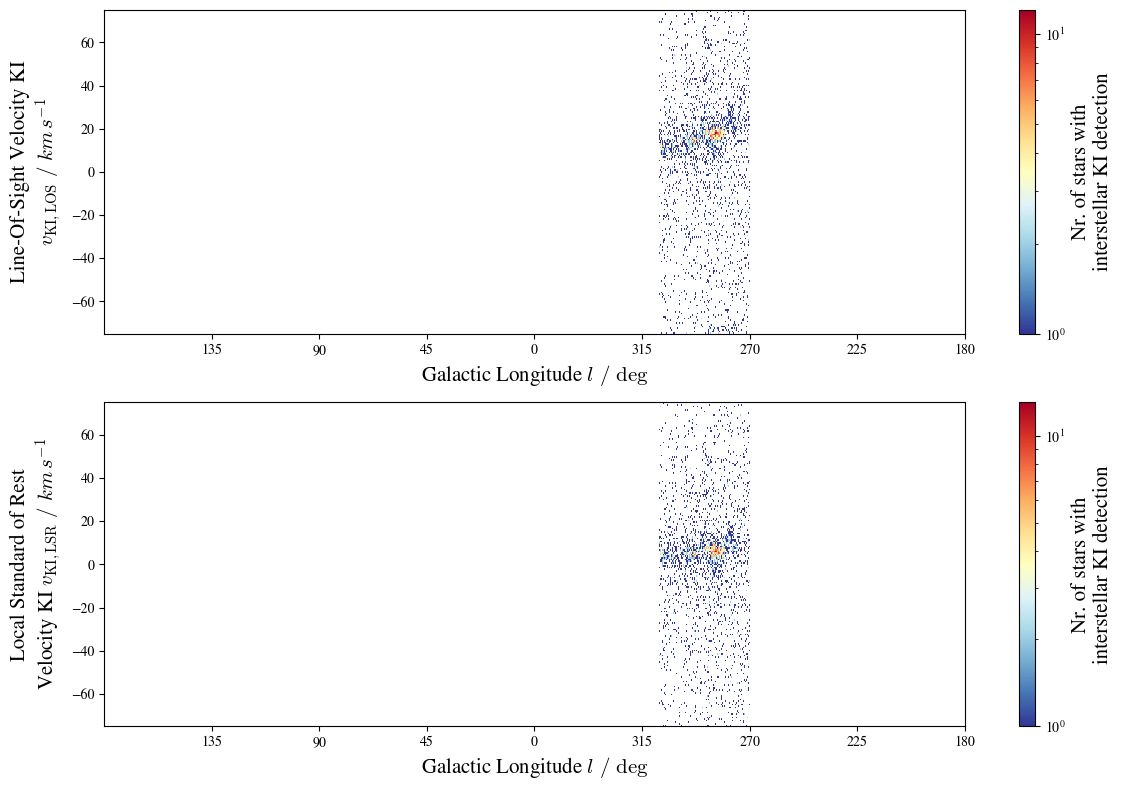

In [ ]:
# VLOS

has_k_is = np.isfinite(galah['rv_k_is_radio']) & np.isfinite(galah['l_flip'])

f, gs = plt.subplots(2,1,figsize=(12,8))

ax = gs[0]
h = ax.hist2d(
    galah['l_flip'][has_k_is],
    np.array(galah['rv_k_is_radio'][has_k_is]),
    bins = (300,np.linspace(-75,75,200)),
    cmin = 1,cmap = 'RdYlBu_r',
    norm = LogNorm()
);
cbar = plt.colorbar(h[-1],ax=ax)
cbar.set_label('Nr. of stars with\ninterstellar KI detection',fontsize=15)
ax.set_xlabel('Galactic Longitude $l~/~\mathrm{deg}$',fontsize=15)
ax.set_ylabel('Line-Of-Sight Velocity KI\n$v_\mathrm{KI,LOS}~/~{km\,s^{-1}}$',fontsize=15)
# ax.set_xlim(ax.get_xlim()[::-1])
xticks = np.arange(0, 360+180, 45)
xticks_name = xticks.copy()
xticks_name[xticks_name >= 360] -= 360
ax.set_xticks(xticks, xticks_name)
ax.set_xlim(360+180, 180)


#
ax = gs[1]

has_k_is = np.isfinite(galah['rv_k_is']) & np.isfinite(galah['l_flip'])

h = ax.hist2d(
    galah['l_flip'][has_k_is],
    np.array(galah['ki_v_lsr_radio'][has_k_is]),
    bins = (300,np.linspace(-75,75,200)),
    cmin = 1,cmap = 'RdYlBu_r',
    norm = LogNorm()
);
cbar = plt.colorbar(h[-1],ax=ax)
cbar.set_label('Nr. of stars with\ninterstellar KI detection',fontsize=15)
ax.set_xlabel('Galactic Longitude $l~/~\mathrm{deg}$',fontsize=15)
ax.set_ylabel('Local Standard of Rest\nVelocity KI $v_\mathrm{KI,LSR}~/~{km\,s^{-1}}$',fontsize=15)
# ax.set_xlim(ax.get_xlim()[::-1])
xticks = np.arange(0,360+180,45)
xticks_name = xticks.copy()
xticks_name[xticks_name >= 360] -= 360
ax.set_xticks(xticks, xticks_name)
ax.set_xlim(360+180,180)

plt.tight_layout()
# plt.savefig('figures/galah_dr4_ism_k_longitude_vs_velocity.pdf',bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
med_dist = np.array(galah['r_med'].data, dtype='float32')

field_ids = np.array(galah['field_id'].data, dtype='int16')
star_ids = np.array(galah['sobject_id'].data, dtype='int64')

ra = galah['ra'].data
dec = galah['dec'].data

ew_k_is = galah['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))
rv_k_is = galah['rv_k_is']

ebv = galah['ebv']

# Read CSV: GALAH stellar catalogue with 3sigma KI detections

In [ ]:
galah_fg_df_csv_file = data_path / 'galah_fg_df_3sigma.csv'
galah_fg_df = pd.read_csv(galah_fg_df_csv_file)
galah_fg_df

,sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,...,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio,ki_flux_std,ki_max_flux,yn
0,140713004601361,b'00000025-7541166',4685221429109310080,b'galah_main',182,b'allstar',56851.773,0.001042,-75.687943,0,...,-41.019988,-7.069331,-104.650508,307.113381,7696.458320,-97.612949,-104.682280,0.009460,0.030888,True
1,140711003901371,b'00000344-8035334',4634293351884119040,b'galah_main',411,b'allstar',56849.777,0.014375,-80.592613,0,...,-36.276474,-7.123088,2.011176,305.515414,7699.198877,9.133986,2.010898,0.013848,0.098077,True
2,140811005001160,b'00000392-7323306',4689447883087062784,b'galah_main',76,b'allstar',56880.710,0.016250,-73.391861,0,...,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853,0.005235,0.061716,True
3,140811005001171,b'00000440-7313079',4689462520335582592,b'galah_main',76,b'allstar',56880.710,0.018292,-73.218887,0,...,-43.400444,-7.024397,-6.399740,307.998606,7698.980342,0.624655,-6.399742,0.005281,0.048886,True
4,140711003901061,b'00000796-8126441',4631183662419506048,b'galah_main',411,b'allstar',56849.777,0.033167,-81.445580,0,...,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791,0.013779,0.102848,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15580,140711003901032,b'23594728-8058587',6352336620255046912,b'galah_main',411,b'allstar',56849.777,359.947052,-80.983002,0,...,-35.895384,-7.122000,1.230774,305.409765,7699.178807,8.352541,1.230541,0.009287,0.066870,True
15581,150828004701380,b'23594998-7856550',6353031550259896064,b'galah_main',321,b'allstar',57262.668,359.958282,-78.948608,2048,...,-37.866417,-7.108079,-186.897080,306.039658,7694.347142,-179.896888,-187.004966,0.023373,0.130459,True
15582,141104003301215,b'23595059-7435243',6379489613954820864,b'galah_main',133,b'allstar',56965.510,359.960754,-74.590111,0,...,-42.075811,-7.047230,8.193784,307.515543,7699.355704,15.240239,8.193009,0.027120,0.192828,True
15583,140711003901037,b'23595079-8107438',6352328000257170048,b'galah_main',411,b'allstar',56849.777,359.961639,-81.128830,0,...,-35.754562,-7.123348,5.670360,305.362962,7699.292855,12.793162,5.669814,0.013037,0.081280,True


In [ ]:
galah_fg_df = galah_fg_df[(galah_fg_df.yn == True) & (galah_fg_df.ew_k_is < 0.2) & (galah_fg_df.r_med > 400.) & (galah_fg_df.age > 1.) & (galah_fg_df.ebv < 1)]
galah_fg_df

,sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,...,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio,ki_flux_std,ki_max_flux,yn
2,140811005001160,b'00000392-7323306',4689447883087062784,b'galah_main',76,b'allstar',56880.710,0.016250,-73.391861,0,...,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853,0.005235,0.061716,True
4,140711003901061,b'00000796-8126441',4631183662419506048,b'galah_main',411,b'allstar',56849.777,0.033167,-81.445580,0,...,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791,0.013779,0.102848,True
5,140711003901030,b'00001085-8105228',4634208693785476224,b'galah_main',411,b'allstar',56849.777,0.045208,-81.089668,88,...,-35.795691,-7.126913,-39.625753,305.359306,7698.129698,-32.502364,-39.629277,0.011397,0.185799,True
6,140711003901040,b'00001107-8109523',4634205120372686848,b'galah_main',411,b'allstar',56849.777,0.046167,-81.164528,0,...,-35.723116,-7.127265,2.524415,305.336690,7699.212165,9.651369,2.524104,0.008755,0.062491,True
7,140711003901067,b'00001294-8134535',4631131229458759168,b'galah_main',411,b'allstar',56849.777,0.053917,-81.581528,2112,...,-35.318838,-7.129096,-109.732138,305.211092,7696.329353,-102.638170,-109.767266,0.013529,0.117537,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15578,150828004701015,b'23593935-7914094',6352928157510667904,b'galah_main',321,b'allstar',57262.668,359.913879,-79.235970,0,...,-37.586190,-7.108262,2.662910,305.958509,7699.215233,9.770853,2.662591,0.011863,0.074429,True
15579,140711003901337,b'23594236-8005456',6352503234922863872,b'galah_main',411,b'allstar',56849.777,359.926544,-80.096031,0,...,-36.754029,-7.115741,3.941643,305.685802,7699.248264,11.056977,3.941235,0.005069,0.096033,True
15582,141104003301215,b'23595059-7435243',6379489613954820864,b'galah_main',133,b'allstar',56965.510,359.960754,-74.590111,0,...,-42.075811,-7.047230,8.193784,307.515543,7699.355704,15.240239,8.193009,0.027120,0.192828,True
15583,140711003901037,b'23595079-8107438',6352328000257170048,b'galah_main',411,b'allstar',56849.777,359.961639,-81.128830,0,...,-35.754562,-7.123348,5.670360,305.362962,7699.292855,12.793162,5.669814,0.013037,0.081280,True


In [ ]:
med_dist = galah_fg_df.r_med

field_ids = galah_fg_df.field_id
star_ids = galah_fg_df.sobject_id

ra = galah_fg_df.ra.values
dec = galah_fg_df.dec.values

# Compute KI column density
ew_k_is = galah_fg_df.ew_k_is.values
n_k_is = np.array(compute_column_density_KI(ew_k_is))
rv_k_is = galah_fg_df.rv_k_is.values

ebv = galah_fg_df.ebv.values

glon = galah_fg_df.l.values
glat = galah_fg_df.b.values

In [ ]:
# Get unique field IDs
unique_field_ids = np.unique(field_ids)

# Compute means for each field_id
field_lb_means = []
for field_id in unique_field_ids:
    mask = (field_ids == field_id)  # Mask rows with the current field_id
    glon_mean = np.mean(glon[mask])
    glat_mean = np.mean(glat[mask])
    field_lb_means.append((field_id, glon_mean, glat_mean))

# Print results
for field_id, glon_mean, glat_mean in field_lb_means:
    print(f"Field ID: {field_id}, Mean Glon: {glon_mean:.2f}, Mean Glat: {glat_mean:.2f}")

Field ID: -6, Mean Glon: 301.32, Mean Glat: -46.13
Field ID: 32, Mean Glon: 302.48, Mean Glat: -46.16
Field ID: 51, Mean Glon: 305.47, Mean Glat: -44.91
Field ID: 57, Mean Glon: 300.02, Mean Glat: -44.89
Field ID: 62, Mean Glon: 290.18, Mean Glat: -44.94
Field ID: 76, Mean Glon: 306.86, Mean Glat: -43.84
Field ID: 88, Mean Glon: 304.52, Mean Glat: -43.62
Field ID: 92, Mean Glon: 301.48, Mean Glat: -43.39
Field ID: 108, Mean Glon: 307.95, Mean Glat: -42.51
Field ID: 120, Mean Glon: 297.77, Mean Glat: -42.48
Field ID: 130, Mean Glon: 287.88, Mean Glat: -42.44
Field ID: 131, Mean Glon: 291.39, Mean Glat: -42.33
Field ID: 132, Mean Glon: 303.16, Mean Glat: -42.04
Field ID: 133, Mean Glon: 306.16, Mean Glat: -41.98
Field ID: 142, Mean Glon: 300.18, Mean Glat: -41.80
Field ID: 177, Mean Glon: 280.44, Mean Glat: -41.18
Field ID: 180, Mean Glon: 292.87, Mean Glat: -40.82
Field ID: 181, Mean Glon: 304.65, Mean Glat: -40.65
Field ID: 190, Mean Glon: 296.79, Mean Glat: -40.57
Field ID: 193, Mean 

In [ ]:
try:
    # Example Usage
    x = np.isfinite(ew_k_is)
    ra = ra[x]  # Random right ascension values
    dec = dec[x]  # Random declination values
    distance = med_dist[x].clip(max = 4999)  # Random distance values
    n_k = n_k_is[x].clip(max = 20)  # Random equivalent width values

    mollweide_histogram(ra, dec, distance, n_k, nside=64)

except:
    print('Could not create Molleide projection. Maybe you do not have healpy installed?')

Could not create Molleide projection. Maybe you do not have healpy installed?


# Sources on map

In [ ]:
# Moment Maps
moment0_file = GASS_data_path / 'moment0_LMC_fg.fits'
tb_file = data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
m0, hdr = fits.getdata(tb_file, header=True)
print(m0.shape)

GASS_nhi_thin_map = 0.018224 * m0

w = WCS(hdr)
print(w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999963 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


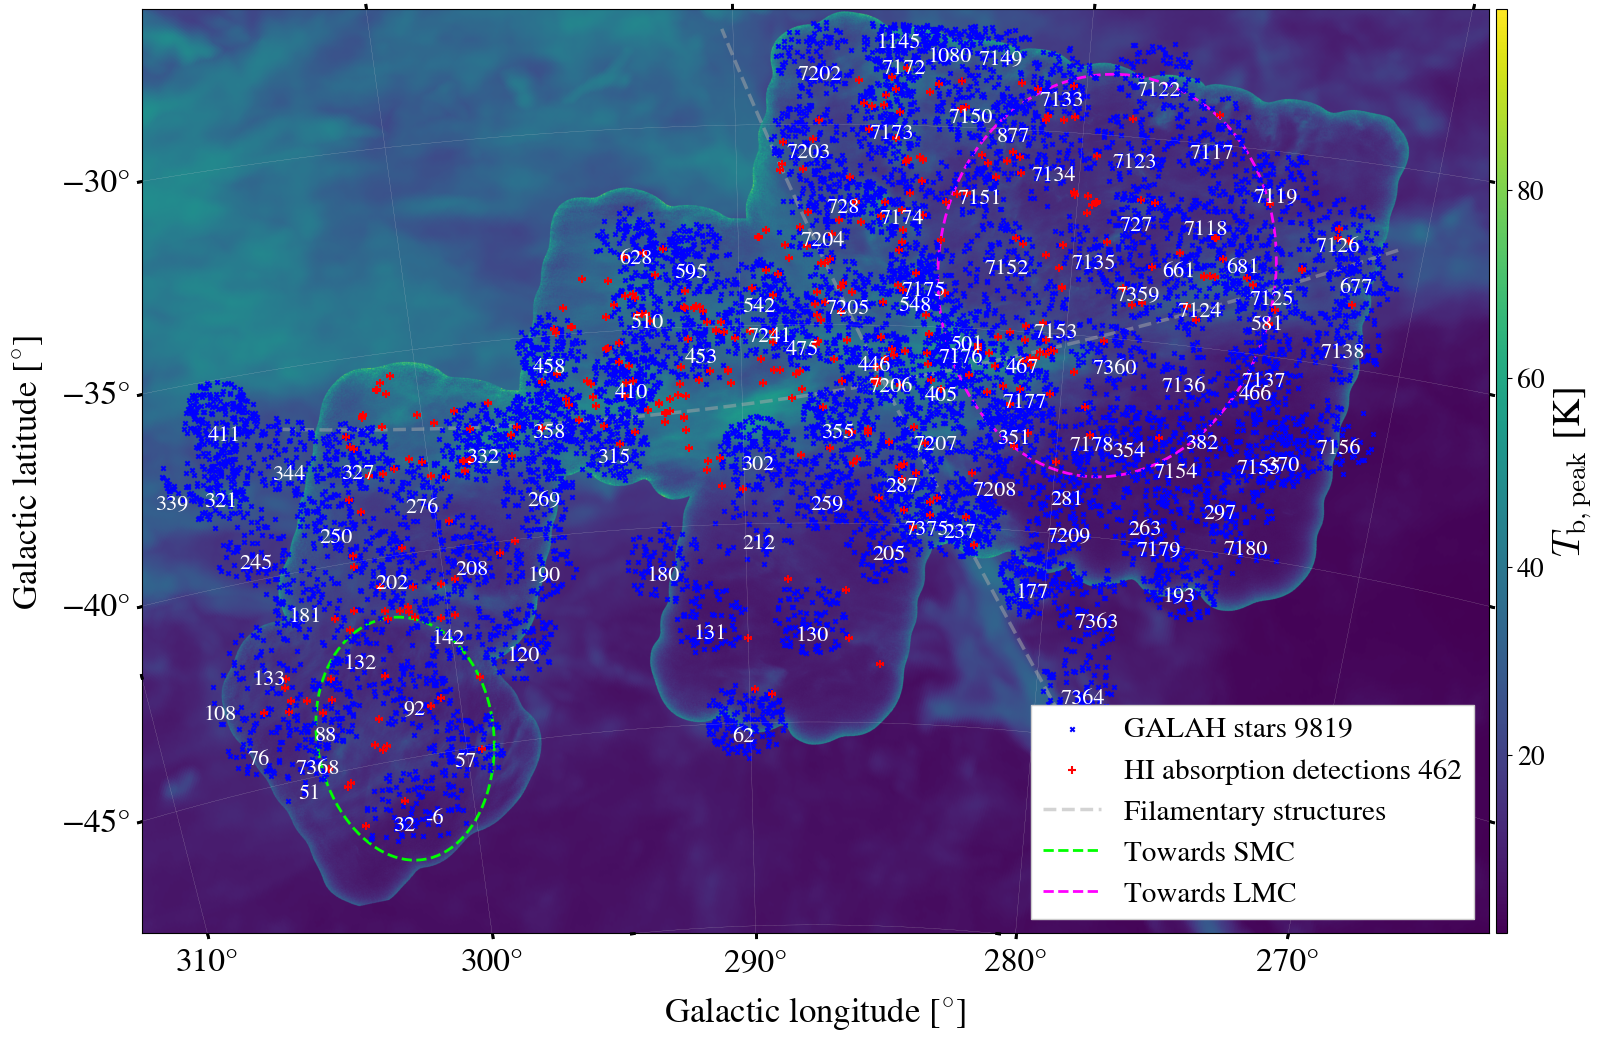

In [ ]:
# Plot
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=WCS(hdr))

# Display the moment map image
im = ax.imshow(m0, cmap='viridis')
# ax.invert_yaxis()  # Flips the Y axis
# ax.invert_xaxis()  # Flips the X axis

ax.scatter(glon, glat,
                 s=10,
                 transform=ax.get_transform('galactic'),
                 marker='x',
                 c='b',
                 alpha=1,
                 label=f'GALAH stars {len(glon)}')
# ploti, = ax.plot([4000], [100], c='orange', marker='x', markersize=15, mew=3, ls='', lw=0, label=f'Absorption detections ({ndet})')
# ploti.set_visible(True)

# ax.scatter(src_gl, src_gb,
#                  s=40,
#                  transform=ax.get_transform('galactic'),
#                  marker='x',
#                  c='gray', # cadetblue
#                  alpha=1,
#                  label='')


ax.scatter(glon_det, glat_det, s=40, c='r', transform=ax.get_transform('galactic'),
           marker='+', # cmap=cmap, vmin=-10, vmax=10., # norm=mpl.colors.LogNorm(vmin=0.01, vmax=0.2), # vmin=0.01, vmax=0.06, # vmax=n_k_is.max(),
           label=f'HI absorption detections {len(glon_det)}')


# ploti, = ax.plot([4000], [100], c='gray', marker='x', markersize=12, mew=3, ls='', lw=0, label='Non$-$detections')
# ploti.set_visible(True)


# ax.plot(gl_boundary, gb_boundary, ls='--', c='skyblue', transform=ax.get_transform('galactic'))



# Print field_id
for field_id, glon_mean, glat_mean in field_lb_means:
    # print(f"Field ID: {field_id}, Mean Glon: {glon_mean:.2f}, Mean Glat: {glat_mean:.2f}")
    # ax.scatter(glon_mean, glat_mean, s=40, transform=ax.get_transform('galactic'), marker='x', c='r', alpha=0.8, label='')
    ax.text(glon_mean+0.5, glat_mean-0.5, str(field_id), transform=ax.get_transform('galactic'), fontsize=16, color='w')



ax.plot(ch_xcirc, ch_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label='Filamentary structures'
       )


ax.plot(cv_xcirc, cv_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label=''
       )


# # Approximate locations of LMC, SMC
ax.plot(SMC_xcirc,
        SMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='lime',
        ls='--',
        label='Towards SMC'
       )
ax.plot(LMC_xcirc,
        LMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='fuchsia',
        ls='--',
        label='Towards LMC'
       )



# Title
# ax.set_title(f"LMC: {nfields} fields, {nsrcs} sources", fontsize=18)

# Add axes labels
ax.set_xlabel("Galactic Longitude [degrees]", fontsize=16)
ax.set_ylabel("Galactic Latitude [degrees]", fontsize=16)

## Color bar
# cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('Optical Depth Noise [%]', rotation=90, labelpad=5., fontsize=15)
# cbar.ax.tick_params(labelsize=14)



# ax.set_xlim(lmc_glon[1], lmc_glon[0])
# ax.set_ylim(lmc_glat[0], lmc_glat[1])

# ax.set_xlim(0, 5000)
# ax.set_ylim(500, 4200)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', fraction=0.008, pad=0.005, aspect=85)
cbar.ax.set_ylabel('$T_\mathrm{b,peak}$ [K]', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=20)


# Title
# ax.set_title(f"LMC: {n_fields} fields, {n_sources} sources", fontsize=18)

# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=25)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=25)

ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)




# Overlay set of RA/Dec Axes
# overlay = ax.get_coords_overlay('galactic')
# overlay.grid(color='white', ls='dotted', lw=0.3)
# overlay[0].set_axislabel('Galactic Longitude [deg]', fontsize=16)
# overlay[1].set_axislabel('Galactic Latitude [deg]', fontsize=16)

ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=21)
ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

# Select a HI absorption detection

In [ ]:
df_det.shape

(462, 45)

In [ ]:
hi_det_src_id = 4
# hi_det_src_id = 279

if False:
    # Example catalogs with glon and glat
    # catalog1 = np.array([[10, 20], [15, 25], [30, 45]])  # (glon, glat) for catalog 1
    # catalog2 = np.array([[glon_star, glat_star]])  # (glon, glat) for catalog 2

    # Convert catalogs to SkyCoord objects
    coords1 = SkyCoord(l=glon*u.deg, b=glat*u.deg, frame='galactic') # GALAH stars
    coords2 = SkyCoord(l=[glon_det[hi_det_src_id]]*u.deg, b=[glat_det[hi_det_src_id]]*u.deg, frame='galactic') # 1 HI obsorption detection

    # Calculate separations and find the closest pair
    idx, sep2d, _ = coords1.match_to_catalog_sky(coords2)

    # Find the closest pair
    closest_pair_idx = np.argmin(sep2d)
    closest_sep = sep2d[closest_pair_idx].deg
    closest_coords1_glon = glon[closest_pair_idx]
    closest_coords1_glat = glat[closest_pair_idx]
    # closest_coords2 = catalog2[idx[closest_pair_idx]]

    # Print results
    print(f"Closest pair:")
    print(f"Star coordinate ID: {closest_pair_idx}")
    print(f"Star coordinates: {closest_coords1_glon, closest_coords1_glat}")


    print(f"HI detection coordinate ID: {idx[closest_pair_idx]}")
    print(f"HI detection coordinates: {glon_det[hi_det_src_id], glat_det[hi_det_src_id]}")
    # print(f"Angular separation: {closest_sep:.4f}")
    print(closest_sep, 'deg')

In [ ]:
def get_angular_distance(glon_src, glat_src, star_glon, star_glat):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    star_glon_rad = np.radians(star_glon)
    star_glat_rad = np.radians(star_glat)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distance_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(star_glat_rad) +
        np.cos(glat_src_rad) * np.cos(star_glat_rad) *
        np.cos(glon_src_rad - star_glon_rad)
    )

    # Convert distances back to degrees
    angular_distance = np.degrees(angular_distance_rad)

    return angular_distance

In [ ]:
def find_nearby_stars(glon_src, glat_src, stars_glon, stars_glat, star_ids, radius_deg, galah_df):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star
    radius_deg : float
        Search radius in degrees

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    stars_glon_rad = np.radians(stars_glon)
    stars_glat_rad = np.radians(stars_glat)
    radius_rad = np.radians(radius_deg)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distances_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(stars_glat_rad) +
        np.cos(glat_src_rad) * np.cos(stars_glat_rad) *
        np.cos(glon_src_rad - stars_glon_rad)
    )

    # Convert distances back to degrees
    angular_distances = np.degrees(angular_distances_rad)

    # Create boolean mask for stars within radius
    mask = angular_distances < radius_deg

    # Collect results for nearby stars
    nearby_coords = {
        'glon': stars_glon[mask],
        'glat': stars_glat[mask],
        'distances': angular_distances[mask],
        'ki_ew_ism': galah_df['ew_k_is'][mask]
    }

    nearby_ids = star_ids[mask]

    return nearby_ids, nearby_coords

In [ ]:
# Example usage:
# glon_src = 30.0  # Source galactic longitude
# glat_src = -0.5  # Source galactic latitude
radius = 0.5     # Search radius in degrees


# Assuming star_ids is a numpy array with star identifiers
nearby_ids, nearby_coords = find_nearby_stars(glon_det[hi_det_src_id],
                                              glat_det[hi_det_src_id],
                                              glon,
                                              glat,
                                              star_ids,
                                              radius,
                                              galah_fg_df
                                              )

# Access the results
print(f'Found {len(nearby_ids)} nearby stars')
print('Star IDs:', nearby_ids)
print('Galactic longitudes:', nearby_coords['glon'])
print('Galactic latitudes:', nearby_coords['glat'])
print('Angular distances (degrees):', nearby_coords['distances'])


# Print results
print(f'HI detection coordinates: {glon_det[hi_det_src_id], glat_det[0]}')
# print(f"Angular separation: {closest_sep:.4f}")
print(nearby_coords['distances'], 'deg')


print(f'nearby_stars_glon: {nearby_coords["glon"]}')
print(f'nearby_stars_glat: {nearby_coords["glat"]}')
# print(f"Angular separation: {closest_sep:.4f}")
print(f'nearby_distances: {nearby_coords["distances"]} deg')

Found 13 nearby stars
Star IDs: 259    140811005001070
274    141104003301330
301    141104003301334
312    140811005001046
339    161116002201185
356    161116002201176
374    141104003301357
379    161116002201194
388    161116002201172
389    161116002201204
395    161116002201195
400    161116002201156
420    161116002201146
Name: sobject_id, dtype: int64
Galactic longitudes: [306.23108413 305.98154544 305.85060763 305.94487339 305.71817627
 305.64587647 305.42081128 305.54040282 305.42819335 305.48959051
 305.44735436 305.334998   305.22369706]
Galactic latitudes: [-43.1525685  -42.79202659 -42.82170698 -43.45400133 -43.28102411
 -43.17658643 -42.73260216 -43.43723573 -43.18601828 -43.54991026
 -43.42932322 -43.02393563 -42.94928509]
Angular distances (degrees): [0.49455388 0.40624923 0.31736113 0.48061481 0.24682319 0.12985187
 0.34484169 0.37691969 0.1604002  0.49225813 0.37847303 0.17241305
 0.27366352]
HI detection coordinates: (np.float64(305.5654628031906), np.float64(-43.21

# Stellar spectra in the field

In [ ]:
gaskap_src = df_det.iloc[hi_det_src_id]

gaskap_src_name = gaskap_src.comp_name
gaskap_field = gaskap_src.sbid
print('GASKAP field: ', gaskap_field)

GASKAP field:  30665


In [ ]:
def gaussianfcn(x, A, mu, fwhm):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def blended_gaussian(x, hgts, cens, widths):
    result = np.zeros_like(x, dtype=float)
    for ai, xi, wi in zip(hgts, cens, widths):
        result += gaussianfcn(x, ai, xi, wi)
    return result

def check_within_component_widths(x0, hgts, cens, widths):
    min_x = float('inf')
    max_x = float('-inf')

    for ai, xi, wi in zip(hgts, cens, widths):
        sigma = wi / (2. * np.sqrt(2. * np.log(2.)))
        component_min = xi - 2.5 * sigma # or 2*sigma
        component_max = xi + 2.5 * sigma # or 2*sigma

        min_x = min(min_x, component_min)
        max_x = max(max_x, component_max)

    return min_x <= x0 <= max_x, min_x, max_x

# For all HI absoprtion detections

In [ ]:
gaskap_galah_matching_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_with_gaussfit_ki_3sigma_thres_matching.csv'
print(gaskap_galah_matching_csv_file)

ggdf = pd.read_csv(gaskap_galah_matching_csv_file)
print(ggdf.shape)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/gaskap_abs_galah_star_ki_ism_with_gaussfit_ki_3sigma_thres_matching.csv
(302, 19)


In [ ]:
ggdf.head()

,src_id,src_name,src_glon,src_glat,nhi,sig_nhi,nhi_thin,star_id,r_med,ew_ki_ism,amp_ki_ism,res_max_ki_ism,ki_ism_vlsr_obs,ki_ism_avg_vlsr_obs,ki_ism_sig_vlsr_obs,emt_min_vlsr,vlsr_hi_ki_diff,vlsr_diff_min,n_nearby_stars
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001115,673.530334,0.044314,0.093995,0.105074,-6.150478,-6.150478,5.000000,-2.045776,4.104702,4.104702,1
1,2,J002223-742825,305.562542,-42.505801,2.909353,0.249468,2.823752,141104003301004,1327.229980,0.032836,0.126684,0.132525,3.705640,3.705640,5.000000,1.225603,2.480036,2.480036,1
2,14,J004222-754838,303.670829,-41.304667,4.393594,0.182630,4.296437,140814006001141,668.953369,0.058141,0.064996,0.106274,9.394238,9.394238,5.000000,9.945510,0.551272,0.551272,1
3,27,J010120-781900,302.288489,-38.799206,5.056057,0.246789,4.842613,150706005901396,1055.759033,0.037592,0.081028,0.124206,4.061161,3.434988,3.535534,5.310693,1.249532,1.249532,2
4,36,J010811-754156,301.554024,-41.384497,4.273245,0.401805,4.051246,150705006401309,931.588501,0.035915,0.065072,0.082032,8.506430,8.506430,5.000000,7.916428,0.590002,0.590002,1


In [ ]:
lambda_rest

7698.9643

Streaming output truncated to the last 5000 lines.
vlsr_hi_ki_diff:  4.0847516634101115
cencnm_idx:  0
emt_min_vlsr:  4.89145512131226
ki_amp:  0.08242125932394156
--------

STAR rv_comp_1:  -20.76216
glon_star, glat_star 276.199 -33.036
HHHHHere: xvlsr_max_res, ki_xvlsr[max_res_id]:  -91.53740604184293 -60.49555580063205
vlsr_hi_ki_diff:  96.42886116315519
cencnm_idx:  0
emt_min_vlsr:  4.89145512131226
ki_amp:  0.042849438696509125
--------

STAR rv_comp_1:  40.79396
glon_star, glat_star 276.113 -33.012
HHHHHere: xvlsr_max_res, ki_xvlsr[max_res_id]:  -97.26023733556937 21.226793606931302
vlsr_hi_ki_diff:  102.15169245688163
cencnm_idx:  0
emt_min_vlsr:  4.89145512131226
ki_amp:  0.03400007024650082
--------

STAR rv_comp_1:  -16.898987
glon_star, glat_star 276.35 -32.969
HHHHHere: xvlsr_max_res, ki_xvlsr[max_res_id]:  10.138380938903419 9.843515326715961
vlsr_hi_ki_diff:  5.246925817591158
cencnm_idx:  0
emt_min_vlsr:  4.89145512131226
ki_amp:  0.04875433619100203
--------

STAR rv_co

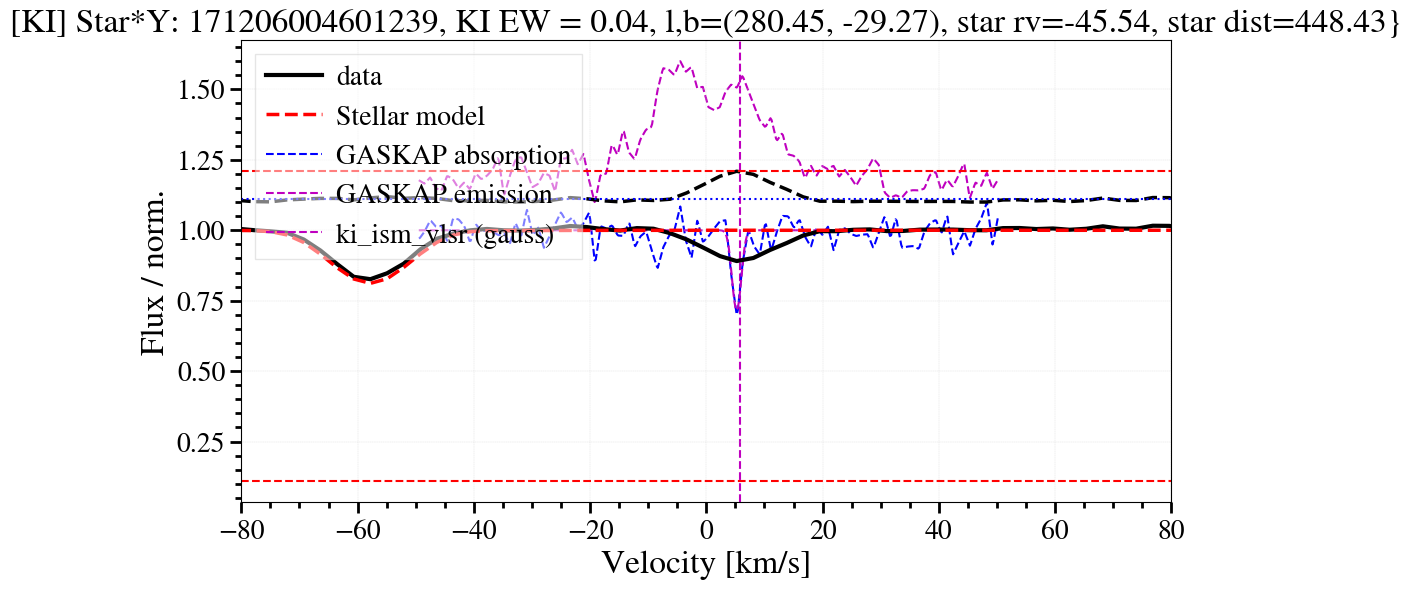

STAR rv_comp_1:  30.738491
glon_star, glat_star 280.389 -29.261
HHHHHere: xvlsr_max_res, ki_xvlsr[max_res_id]:  6.449777073521789 162.6742037857658
vlsr_hi_ki_diff:  1.2294204204619819
cencnm_idx:  0
emt_min_vlsr:  5.220356653059807
ki_amp:  0.0920810751096313
--------

STAR rv_comp_1:  -4.3027945
glon_star, glat_star 280.492 -29.219
HHHHHere: xvlsr_max_res, ki_xvlsr[max_res_id]:  6.701396421625237 7.635166828841218
vlsr_hi_ki_diff:  1.48103976856543
cencnm_idx:  0
emt_min_vlsr:  5.220356653059807
ki_amp:  0.055205617303819565
--------

STAR rv_comp_1:  24.92138
glon_star, glat_star 280.543 -29.213
HHHHHere: xvlsr_max_res, ki_xvlsr[max_res_id]:  0.3822945438011356 -4.302369110404239
vlsr_hi_ki_diff:  4.838062109258671
cencnm_idx:  0
emt_min_vlsr:  5.220356653059807
ki_amp:  0.03908531503236481
--------

hisrc_id, gaskap_field, gaskap_src_name, k_min and vlsr_diff_min, r_med:  441 441 33047 J060035-701218 13 0.539454936615086 448.4271
5.759811589674893

src_glon, src_glat:  281.03539610

In [ ]:
radius = 0.5                # Search radius in degrees, ~1.5 pc
dib5780_lambda_rest = 5780. # Angstroms

for hi_det_src_id in range(462):
    if hi_det_src_id in existing_src_id:
        continue

    # GASKAP source
    gaskap_src = df_det.iloc[hi_det_src_id]

    gaskap_src_name = gaskap_src.comp_name
    gaskap_field = gaskap_src.sbid

    nhi = gaskap_src.nhi
    sig_nhi = gaskap_src.signhi
    nhi_thin = gaskap_src.nhi_thin

    src_glon = gaskap_src.glon
    src_glat = gaskap_src.glat
    print('src_glon, src_glat: ', src_glon, src_glat)


    # HI data: Open and load the pickle file
    gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'


    with open(gaskap_src_file, 'rb') as f:  # "rb" mode means read in binary
        gaskap_res_data = pickle.load(f)


    gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
    gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)

    vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
    sigemt_gaskap = gaskap_res_data['sigemt']
    emt_gaskap = gaskap_res_data['emt']

    ncnm = gaskap_res_data['ncnm']
    hgtcnm = gaskap_res_data['hgtcnm']
    cencnm = gaskap_res_data['cencnm']
    widcnm = gaskap_res_data['widcnm']

    # compute sum of gaussians
    hi_tau_arr = np.zeros_like(vlsr_gaskap)
    for i in range(ncnm):
        hi_tau_arr += gaussian(vlsr_gaskap, hgtcnm[i], cencnm[i], widcnm[i])


    # Assuming star_ids is a numpy array with star identifiers
    nearby_ids, nearby_coords = find_nearby_stars(glon_det[hi_det_src_id],
                                                  glat_det[hi_det_src_id],
                                                  glon,
                                                  glat,
                                                  star_ids,
                                                  radius,
                                                  galah_fg_df
                                                  )
    n_nearby_stars = len(nearby_ids)
    print(f'GASKAP src {gaskap_src_name}: Found {n_nearby_stars} nearby stars')

    mask = np.isin(galah['sobject_id'], nearby_ids)
    selected_close_stars = galah[mask]


    # Find the associated KI absorption from nearby stars
    vlsr_diff_min = 999.
    k_min         = 0
    emt_min_vlsr  = -999.

    star_id_selected   = -999
    ew_ki_ism_selected = -999.
    ki_amp_selected    = -999.

    ki_nu_max_res_selected   = -999.
    ki_max_res_selected      = -999.
    ki_ism_vlsr_obs_selected = -999.

    emt_min_vlsr_selected    = -999.
    vlsr_hi_ki_diff_selected = -999.
    star_r_med_selected      = -999.


    ki_amp_stars      = []
    ki_max_res_stars  = []
    ki_dist_stars     = []
    ki_ang_dist_stars = []

    # For uncertainties/errorbars
    gaskap_star_ids = []
    star_med_dists = []
    ki_ism_ews     = []

    ki_ism_obs_vlsrs = []
    emt_min_vlsrs    = []
    vlsr_hi_ki_diffs = []

    for k, (star_id, closest_coords_glon, closest_coords_glat, sep_distance) in enumerate(zip(nearby_ids, nearby_coords['glon'], nearby_coords['glat'], nearby_coords['distances'])):

        closest_star_info = galah[galah['sobject_id'] == star_id]

        field_id = closest_star_info['field_id'].data[0]
        path = data_path / 'galah' / f'field_{field_id}'
        make_dir(path)

        sobject_id_str = str(star_id)
        output_star_id_file = path / f'{sobject_id_str}_allstar_fit_spectrum.fits'

        download_galah_data(path, star_id)

        # stellar data: wavelength, flux, model
        tmp_spec_table = Table.read(output_star_id_file)

        wavelength = tmp_spec_table['wave']
        flux = tmp_spec_table['sob']
        flux_mod = tmp_spec_table['smod']

        # for KI
        waverange_idx = np.where((wavelength > 7695.5) & (wavelength < 7704.))[0] # 7720
        ki_wavelength = np.array(wavelength[waverange_idx])
        ki_flux = np.array(flux[waverange_idx])
        ki_flux_mod = np.array(flux_mod[waverange_idx])

        star_glon = closest_star_info['l'].data[0]
        star_glat = closest_star_info['b'].data[0]

        star_rv_comp_1 = closest_star_info['rv_comp_1'].data[0] # km/s
        print('STAR rv_comp_1: ', star_rv_comp_1)

        # Residuels, |model - data|
        res = np.abs(ki_flux_mod - ki_flux)
        max_res_id = np.argmax(res)
        ki_nu_max_res = ki_wavelength[max_res_id]


        # VSLRK of the max KI residual
        ki_ism_vlsr_obs = wavelength_to_vlsrk_with_galah_correction(ki_nu_max_res, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)

        # the width of Ki absorption feature (in Angstrom)
        sigma_k_ism_star_val = closest_star_info['sigma_k_is'].data[0]

        # the Equivalent width of Ki absorption feature (in Angstrom)
        ki_ew_ism_star_val = closest_star_info['ew_k_is'].data[0]

        # the Amplitude of Ki absorption feature (flux vs Angstrom)
        ki_amp = ki_ew_ism_star_val / sigma_k_ism_star_val / np.sqrt(2.*np.pi) # See Sven's email "KI line depth from EW and width"

        # To VLSRK
        ki_xvlsr = wavelength_to_vlsrk_with_galah_correction(ki_wavelength, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)


        ki_ew_ism_star = str(np.round(ki_ew_ism_star_val, 3))
        glon_star = np.round(closest_star_info['l'].data[0], 3)
        glat_star = np.round(closest_star_info['b'].data[0], 3)
        print('glon_star, glat_star', glon_star, glat_star)

        # distance to star
        star_med_dist = closest_star_info['r_med'].data[0] # pc

        # Convert angular separation to radians
        angular_sep_rad = np.radians(sep_distance)

        # Compute linear separation
        linear_sep_pc = star_med_dist * angular_sep_rad

        min_emt_id = np.argmin(emt_gaskap)
        emt_min_vlsr = vlsr_gaskap[min_emt_id]


        # Plot spectra
        res = np.abs(ki_flux_mod - ki_flux)
        res_std = np.std( np.concatenate((res[:5], res[-5:])) )
        max_res_id = np.argmax(res)
        max_res_val = res[max_res_id]
        xvlsr_max_res = closest_star_info['ki_v_lsr_radio'].data[0] # From Gaussian fit now, before it was ki_xvlsr[max_res_id]
        print('HHHHHere: xvlsr_max_res, ki_xvlsr[max_res_id]: ', xvlsr_max_res, ki_xvlsr[max_res_id])


        # Check KI_VLSR is in HI absorption range?
        ki_vlsr_inyn, vlsr_left, vlsr_right = check_within_component_widths(xvlsr_max_res, hgtcnm, cencnm, widcnm)

        min_ki_mod_id = np.argmin(ki_flux_mod)
        ki_xvlsr_min_mod = ki_xvlsr[min_ki_mod_id]

        cencnm_idx = np.argmin(np.abs(cencnm - xvlsr_max_res))
        emt_min_vlsr = cencnm[cencnm_idx]
        vlsr_hi_ki_diff = np.abs(xvlsr_max_res - emt_min_vlsr) # compare HI absorption line with KI absorption velocity (using closest HI absorption line)
        print('vlsr_hi_ki_diff: ', vlsr_hi_ki_diff)
        print('cencnm_idx: ', cencnm_idx)
        print('emt_min_vlsr: ', emt_min_vlsr)
        print('ki_amp: ', ki_amp)
        print('--------')
        print()


        # Conditions/criteria to match KI spectra to HI spectra in velocity
        vlsr_hi_ki_diff_cond = (vlsr_hi_ki_diff < 6.)
        ki_ew_ism_star_cond = (ki_ew_ism_star_val > 0.029)
        star_med_dist_cond = (star_med_dist > 230.)
        ki_ism_vlsr_obs_cond = (np.abs(ki_ism_vlsr_obs) < 30.)
        ki_max_res_cond = (max_res_val > 2.5*res_std)
        ki_ism_stellar_mod_vlsr_cond = (np.abs(ki_xvlsr_min_mod - xvlsr_max_res) > 15.)

        all_conds = (ki_ew_ism_star_cond and
                     vlsr_hi_ki_diff_cond and
                     star_med_dist_cond and
                     ki_ism_vlsr_obs_cond and
                     ki_max_res_cond and
                     ki_ism_stellar_mod_vlsr_cond and
                     ki_vlsr_inyn
                    )



        if all_conds:
            # Plot
            fig = plt.figure(figsize=(12,6))
            ax = fig.add_subplot(111)

            ax.plot(ki_xvlsr, ki_flux, 'k-', lw=3., label='data')
            ax.plot(ki_xvlsr, ki_flux_mod, 'r--', lw=2.5, label='Stellar model')
            ax.plot(ki_xvlsr, 1.1 + res, 'k--', lw=2.5, label='') # | model - data |


            # Calculate the Gaussian curve for the defined velocity range
            gaussian_curve = gaussian(velocity_range, 0.15, xvlsr_max_res, 4.)


            ax.plot(vlsr_gaskap, emt_gaskap, 'b--', zorder=0, label='GASKAP absorption')
            ax.plot(vlsr_gaskap, np.exp(-hi_tau_arr), 'm--', zorder=0, label='') # GASKAP absorption fit
            ax.plot(vlsr_gaskap, 1.1 + 0.5*normalize_spectrum(gaskap_em_closest_em_profile), 'm--', zorder=0, label='GASKAP emission')

            ax.axvline(x=xvlsr_max_res, color='m', ls='--', zorder=-2, label='ki_ism_vlsr (gauss)')

            ax.axhline(y = ki_amp, color = 'r', linestyle = '--')
            ax.axhline(y = ki_amp + 1.1, color = 'r', linestyle = '--')
            ax.axhline(y = 3.*res_std + 1.1, color = 'b', linestyle = ':')

            ax.set_xlabel(r'Velocity [km/s]', fontsize=24)
            ax.set_ylabel(r'Flux / norm.', fontsize=24)


            selected_yn = '*' if all_conds else ''
            ki_in_yn = 'Y' if ki_vlsr_inyn else 'N'
            ax.set_title(f'[KI] Star{selected_yn}{ki_in_yn}: {sobject_id_str}, KI EW = {ki_ew_ism_star}, ' + \
                         'l,b=(%5.2f, %5.2f), ' % (glon_star, glat_star) + \
                         'star rv=%5.2f, star dist=%5.2f}' % (star_rv_comp_1, star_med_dist),
                         fontsize=24)
            print(f'[KI] Star{selected_yn}{ki_in_yn}: {sobject_id_str}, KI EW = {ki_ew_ism_star}, KI amp = {ki_amp}, ' + \
                         'l,b=(%5.2f, %5.2f), ' % (glon_star, glat_star) + \
                         'star rv=%5.2f, star dist=%5.2f}' % (star_rv_comp_1, star_med_dist))

            # Add axes labels
            ax.minorticks_on()
            ax.tick_params(axis='x', labelsize=20, pad=4)
            ax.tick_params(axis='y', labelsize=20)
            ax.tick_params(which='both', width=2)
            ax.tick_params(which='major', length=8)
            ax.tick_params(which='minor', length=4)

            ax.set_xlim(-80, 80.)

            ymin_flux = np.min(np.min(flux_mod))
            ymax_flux = np.max(flux)
            # ax.set_ylim(, 80.)


            ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
            leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=0.5) # handletextpad=-2.0
            # [item.set_visible(False) for item in leg.legend_handles]

            # set the spacing between subplots
            plt.subplots_adjust(left=None,
                                bottom=None,
                                right=None,
                                top=None,
                                wspace=0.2,
                                hspace=0.3
                                )

            # Save: spectra_eg.png
            # plt.tight_layout()
            plt.show()
            plt.close()
        # End - if: plot

        if not all_conds:
            continue

        if ((vlsr_hi_ki_diff <= vlsr_diff_min) and (ki_amp >= ki_amp_selected)):
            vlsr_diff_min = vlsr_hi_ki_diff
            k_min = k

            star_id_selected         = star_id
            star_r_med_selected      = star_med_dist
            ew_ki_ism_selected       = ki_ew_ism_star_val
            ki_ism_vlsr_obs_selected = xvlsr_max_res # ki_ism_vlsr # ki_ism_vlsr_obs
            emt_min_vlsr_selected    = emt_min_vlsr
            vlsr_hi_ki_diff_selected = vlsr_hi_ki_diff
            ki_amp_selected          = ki_amp
            ki_max_res_selected      = max_res_val
        # End - if: select a star along GASKAP line of sight

        # For errorbars
        gaskap_star_ids.append(star_id)
        star_med_dists.append(star_med_dist)

        ki_ism_ews.append(ki_ew_ism_star_val)
        ki_ism_obs_vlsrs.append(xvlsr_max_res) # ki_ism_vlsr
        emt_min_vlsrs.append(emt_min_vlsr)
        vlsr_hi_ki_diffs.append(vlsr_hi_ki_diff)

        if ki_amp > 2.7*res_std:
            ki_amp_stars.append(ki_amp)
            ki_max_res_stars.append(max_res_val)
            ki_dist_stars.append(star_med_dist)
            ki_ang_dist_stars.append(sep_distance)
        # End - if: criteria on the 3sigma threshold for nearby stars
    # End - for: nearby stars

    # ki_amp_dist_dict[hi_det_src_id]['ki_amp']            = ki_amp_stars
    # ki_amp_dist_dict[hi_det_src_id]['star_dist']         = ki_dist_stars
    # ki_amp_dist_dict[hi_det_src_id]['star_angular_dist'] = ki_ang_dist_stars

    n_nearby_stars = len(gaskap_star_ids)
    ki_ism_sig_vlsr_obs_val = 5. if (n_nearby_stars == 0) else 5. / np.sqrt(n_nearby_stars)
    ki_ism_avg_vlsr_obs_val = -999. if (len(ki_ism_obs_vlsrs) == 0) else np.mean(np.array(ki_ism_obs_vlsrs))

    new_row = {'src_id': hi_det_src_id,
                'src_name': gaskap_src_name,
                'src_glon': src_glon,
                'src_glat': src_glat,
                'nhi': nhi,
                'sig_nhi': sig_nhi,
                'nhi_thin': nhi_thin,
                'star_id': star_id_selected,
                'r_med': star_r_med_selected,
                'ew_ki_ism': ew_ki_ism_selected,
                'amp_ki_ism': ki_amp_selected,
                'res_max_ki_ism': ki_max_res_selected,
                'ki_ism_vlsr_obs': ki_ism_vlsr_obs_selected,
                'ki_ism_avg_vlsr_obs': ki_ism_avg_vlsr_obs_val,
                'ki_ism_sig_vlsr_obs': ki_ism_sig_vlsr_obs_val,
                'emt_min_vlsr': emt_min_vlsr_selected,
                'vlsr_hi_ki_diff': vlsr_hi_ki_diff_selected,
                'vlsr_diff_min': vlsr_diff_min,
                'n_nearby_stars': n_nearby_stars,
                }
    ggdf.loc[len(ggdf)] = new_row


    print('hisrc_id, gaskap_field, gaskap_src_name, k_min and vlsr_diff_min, r_med: ', hi_det_src_id, hi_det_src_id, gaskap_field, gaskap_src_name, k_min, vlsr_diff_min, star_r_med_selected)
    print(ki_ism_vlsr_obs_selected)
    print()
# End - for: GASKAP abs sources

In [ ]:
ggdf

,src_id,src_name,src_glon,src_glat,nhi,sig_nhi,nhi_thin,star_id,r_med,ew_ki_ism,amp_ki_ism,res_max_ki_ism,ki_ism_vlsr_obs,ki_ism_avg_vlsr_obs,ki_ism_sig_vlsr_obs,emt_min_vlsr,vlsr_hi_ki_diff,vlsr_diff_min,n_nearby_stars
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001115,673.530334,0.044314,0.093995,0.105074,-6.150478,-6.150478,5.000000,-2.045776,4.104702,4.104702,1
1,2,J002223-742825,305.562542,-42.505801,2.909353,0.249468,2.823752,141104003301004,1327.229980,0.032836,0.126684,0.132525,3.705640,3.705640,5.000000,1.225603,2.480036,2.480036,1
2,14,J004222-754838,303.670829,-41.304667,4.393594,0.182630,4.296437,140814006001141,668.953369,0.058141,0.064996,0.106274,9.394238,9.394238,5.000000,9.945510,0.551272,0.551272,1
3,27,J010120-781900,302.288489,-38.799206,5.056057,0.246789,4.842613,150706005901396,1055.759033,0.037592,0.081028,0.124206,4.061161,3.434988,3.535534,5.310693,1.249532,1.249532,2
4,36,J010811-754156,301.554024,-41.384497,4.273245,0.401805,4.051246,150705006401309,931.588501,0.035915,0.065072,0.082032,8.506430,8.506430,5.000000,7.916428,0.590002,0.590002,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,441,J060035-701218,280.580328,-29.693709,6.208343,0.474431,6.018040,171206004601239,448.427094,0.040288,0.109166,0.109367,5.759812,5.759812,5.000000,5.220357,0.539455,0.539455,1
458,443,J060111-703609,281.035396,-29.629529,6.708708,1.209205,6.776281,-999,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,5.000000,-999.000000,-999.000000,999.000000,0
459,445,J060141-723832,283.376091,-29.498775,7.501124,1.099728,7.111023,-999,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,5.000000,-999.000000,-999.000000,999.000000,0
460,446,J060234-683041,278.628197,-29.555911,4.567334,0.985549,4.231187,-999,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,5.000000,-999.000000,-999.000000,999.000000,0


In [ ]:
ggdf[ggdf['star_id'] > 0].shape

(302, 19)

In [ ]:
current_ggdf = ggdf[ggdf['star_id'] > 0]
current_ggdf.shape

(302, 19)

In [ ]:
ki_ism_vlsr_obs_selected = current_ggdf['ki_ism_vlsr_obs']
ki_ism_avg_vlsr_obs = current_ggdf['ki_ism_avg_vlsr_obs']
emt_min_vlsrs = current_ggdf['emt_min_vlsr']
ki_ism_sig_vlsr_obs = current_ggdf['ki_ism_sig_vlsr_obs']

In [ ]:
gaskap_galah_matching_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_with_gaussfit_ki_3sigma_thres_matching.csv'
print(gaskap_galah_matching_csv_file)
current_ggdf.to_csv(gaskap_galah_matching_csv_file, index=False)

In [ ]:
vlsrk_diff = (ki_ism_vlsr_obs_selected - emt_min_vlsrs)
print(np.min(vlsrk_diff), np.max(vlsrk_diff))

-4.10470226479761 5.336276442602353


In [ ]:
vlsrk_diff = (emt_min_vlsrs - ki_ism_vlsr_obs_selected)

In [ ]:
stats_series = pd.DataFrame(vlsrk_diff).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,246.000000
mean,-0.750742
std,1.421610
min,-5.336276
25%,-1.754646
50%,-0.595366
75%,0.033567
max,4.104702


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

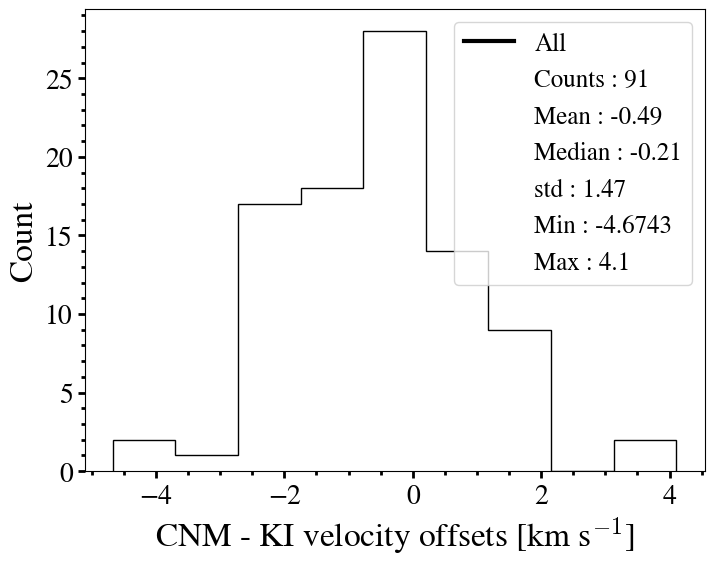

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(vlsrk_diff, bins=np.linspace(np.nanmin(vlsrk_diff), np.nanmax(vlsrk_diff), 10),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'k-', lw=3, label=f'All')
ploti.set_visible(True)


for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

# plt.title(f'Optical depth, sightlines decomposed: {ndet_total}, total N_CNM_components: {total_ncnm}')
plt.xlabel(r'CNM - KI velocity offsets [km s$^{-1}$]', fontsize=24)
plt.ylabel(r'Count', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

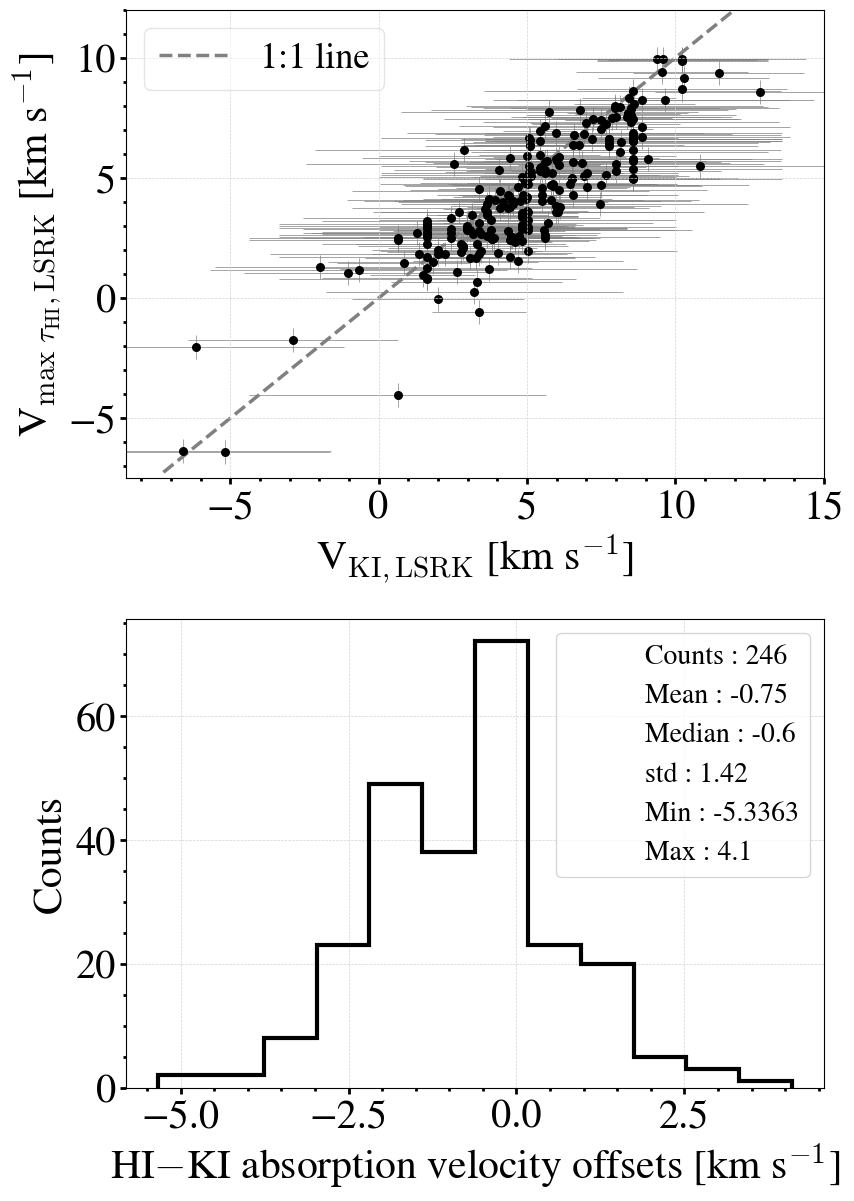

In [ ]:
# Plot
fig = plt.figure(figsize=(9,14))

ax = plt.subplot(211)

ax.errorbar(ki_ism_vlsr_obs_selected, emt_min_vlsrs,
             xerr=ki_ism_sig_vlsr_obs*(ki_ism_sig_vlsr_obs>0.), yerr=0.5, zorder=1,
             ls='None', markersize=2,
             markeredgecolor='lightgrey', markeredgewidth=1,
             ecolor='grey', elinewidth=0.5,
             label='')


ax.scatter(ki_ism_vlsr_obs_selected, emt_min_vlsrs, zorder=1, s=30, marker='o',
                 c='k', #cmap=cm,
                 label=f'')


ax.plot([-7.25, 12.], [-7.25, 12.], c='gray', ls='--', lw='2.5', zorder=-1, label='1:1 line')



ax.set_ylabel(r'V$_\mathrm{max ~ \tau_\mathrm{HI}, LSRK}$ [km s$^{-1}$]', fontsize=30)
ax.set_xlabel(r'V$_\mathrm{KI, LSRK}$ [km s$^{-1}$]', fontsize=30, fontweight='normal')

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=4)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.set_xlim(-8.5, 15.)
ax.set_ylim(-7.5, 12.)

ax.legend(loc='upper left', fancybox=True, framealpha=0.5, labelcolor='k', fontsize=26)
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)






###
ax = plt.subplot(212)

ax.hist(vlsrk_diff, bins=np.linspace(np.nanmin(vlsrk_diff), np.nanmax(vlsrk_diff), 13),
         density=False, color='k', histtype='step', ls='-', linewidth=3, label='')

ploti, = ax.plot([], [], 'k-', lw=3, label=f'')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = ax.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)



ax.set_ylabel(r'Counts', fontsize=30)
ax.set_xlabel(r'HI$-$KI absorption velocity offsets [km s$^{-1}$]', fontsize=30)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=4)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)



ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax.legend(loc='upper right', fontsize=20)





# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.3
                    )

plt.show()